# 状態空間モデル（SARIMAX）でOVを予測する

このノートブックでは `statsmodels` の `SARIMAX`（状態空間モデル・カルマンフィルタ）を使って `OV` を予測します。

- データ: `../data/raw/kadai.xlsx`
- 予測: 末尾500点をテストとして予測し、RMSEとグラフを出力
- オプション: `X1..X83` などを外生変数（exog）として追加可能


In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

# --- パス解決（project root / notebook どちらで実行してもOK）---
CWD = Path.cwd().resolve()
if (CWD / "data" / "raw" / "kadai.xlsx").exists():
    ROOT = CWD
elif (CWD.parent / "data" / "raw" / "kadai.xlsx").exists():
    ROOT = CWD.parent
else:
    raise FileNotFoundError("kadai.xlsx が見つかりません。プロジェクト直下か notebook 配下から実行してください")

DATA_PATH = ROOT / "data" / "raw" / "kadai.xlsx"

# --- データ読み込み ---
df = pd.read_excel(DATA_PATH)
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# 時系列として並べる（OVを観測系列にする）
df = df.sort_values("process_end_time").reset_index(drop=True)

y = df["OV"].astype(float)
y.describe()

count    2276.000000
mean      128.035745
std        62.160991
min        25.718750
25%        80.438945
50%       112.385600
75%       168.245275
max       418.405600
Name: OV, dtype: float64

In [2]:
# --- 外生変数（exog）を使う場合 ---
# まずは exog=None（OV単体の時系列）で動かし、必要ならここをONにしてください。
USE_EXOG = False

if USE_EXOG:
    exog_cols = [f"X{i}" for i in range(1, 84)]
    exog = df[exog_cols].astype(float)
else:
    exog_cols = []
    exog = None

len(y), (len(exog_cols) if exog is not None else 0)

(2276, 0)

In [3]:
# --- 学習/テスト分割（最後の500点をテスト）---
test_size = 500
if len(y) <= test_size + 10:
    raise ValueError(f"データが少なすぎます: len(y)={len(y)}")

y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
exog_train = exog.iloc[:-test_size] if exog is not None else None
exog_test = exog.iloc[-test_size:] if exog is not None else None

y_train.shape, y_test.shape

((1776,), (500,))

In [4]:
# --- 状態空間モデル（SARIMAX）---
# (p,d,q) は最初は小さく。必要なら複数試してRMSEが良いものを採用。
order = (1, 1, 1)

model = sm.tsa.SARIMAX(
    y_train,
    exog=exog_train,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                     OV   No. Observations:                 1776
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9153.236
Date:                Tue, 20 Jan 2026   AIC                          18312.472
Time:                        23:03:44   BIC                          18328.913
Sample:                             0   HQIC                         18318.546
                               - 1776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0516      0.023     -2.230      0.026      -0.097      -0.006
ma.L1         -0.8245      0.014    -60.908      0.000      -0.851      -0.798
sigma2      1784.5335     53.784     33.179      0.0

RMSE: 67.65918056438535


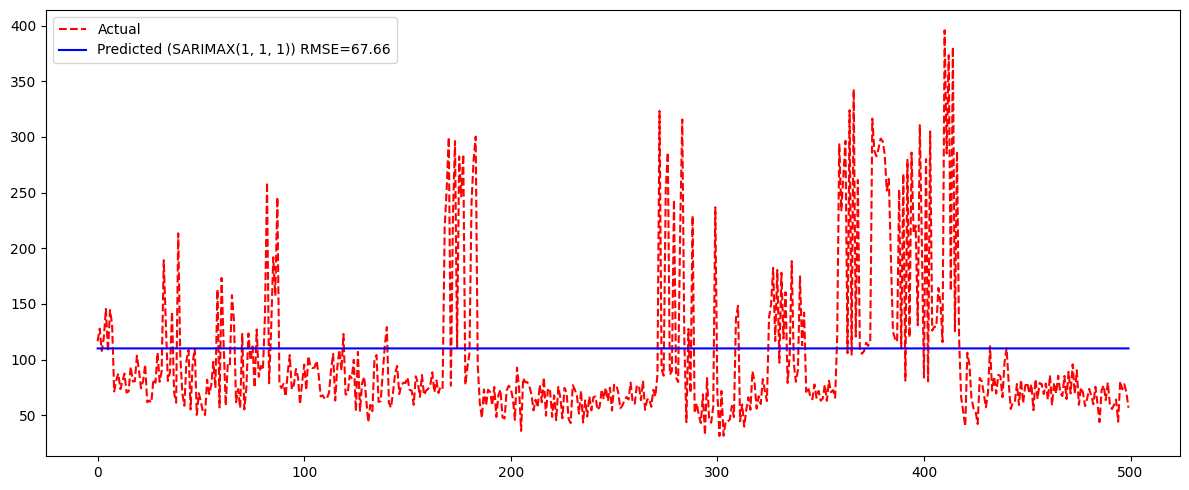

In [5]:
# --- 予測（テスト期間）---
pred = res.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean

rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
print("RMSE:", rmse)

plt.figure(figsize=(12, 5))
plt.plot(y_test.reset_index(drop=True), label="Actual", color="red", linestyle="--")
plt.plot(pd.Series(pred).reset_index(drop=True), label=f"Predicted (SARIMAX{order}) RMSE={rmse:.2f}", color="blue")
plt.legend()
plt.tight_layout()
plt.show()

## 次の一手（精度改善）

- `order=(p,d,q)` を複数試してRMSEが良いものを選ぶ
- `USE_EXOG=True` にして外生変数（`X1..X83`）を投入する（ただし過学習に注意）
- ラグ特徴（例：`OV_lag1` など）をexogとして追加して「状態空間 + 追加特徴」で精度を上げる
